#  A/B-тест

### Задача

Приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

## Часть 1. Приоритизация гипотез.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    hypothesis = pd.read_csv('/Users/666/Documents/Data Analysis/Проекты/df/hypothesis.csv')
    orders = pd.read_csv('/Users/666/Documents/Data Analysis/Проекты/df/orders.csv')
    visitors = pd.read_csv('/Users/666/Documents/Data Analysis/Проекты/df/visitors.csv')

### Смотрю данные

In [3]:
pd.options.display.max_colwidth = 1

### Hypothesis

In [4]:
display(hypothesis)
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Hypothesis — краткое описание гипотезы;

Reach — охват пользователей по 10-балльной шкале;

Impact — влияние на пользователей по 10-балльной шкале;

Confidence — уверенность в гипотезе по 10-балльной шкале;

Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

### Orders

In [5]:
display(orders)
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


transactionId — идентификатор заказа;

visitorId — идентификатор пользователя, совершившего заказ;

date — дата, когда был совершён заказ;

revenue — выручка заказа;

group — группа A/B-теста, в которую попал заказ.

### Visitors

In [6]:
display(visitors)
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


date — дата;

group — группа A/B-теста;

visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Предобработка

In [7]:
hypothesis.columns = [name.lower() for name in hypothesis.columns]
orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace=True)
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [8]:
orders.duplicated().sum(), visitors.duplicated().sum()

(0, 0)

Дубликатов нет

### Применяю фреймворк ICE для приоритизации гипотез.

In [9]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
hypothesis.sort_values(by = 'ICE', ascending = False) 

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


### Применяю фреймворк RICE для приоритизации гипотез.

In [10]:
hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
hypothesis.sort_values(by = 'RICE', ascending = False) 

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Фреймворк RICE при подсчете учитывает параметр Reach(охват), поэтому гипотеза с индексом 7 вышла на первое место "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"

## Часть 2. Анализ A/B-теста

## График кумулятивной выручки по группам.

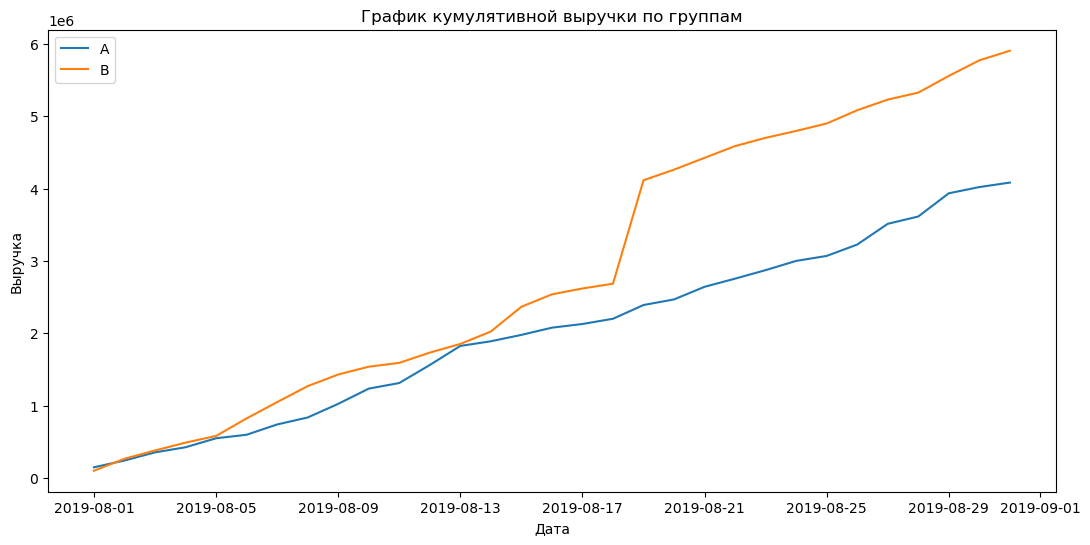

In [11]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

plt.figure(figsize=(13, 6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

Из графика видна доминация группы B, на протяжении всего наблюдения, так же можно наблюдать резкий скачок выручки у группы B, я это связываю с выбросом, аномально крупным заказом

## График кумулятивного среднего чека по группам

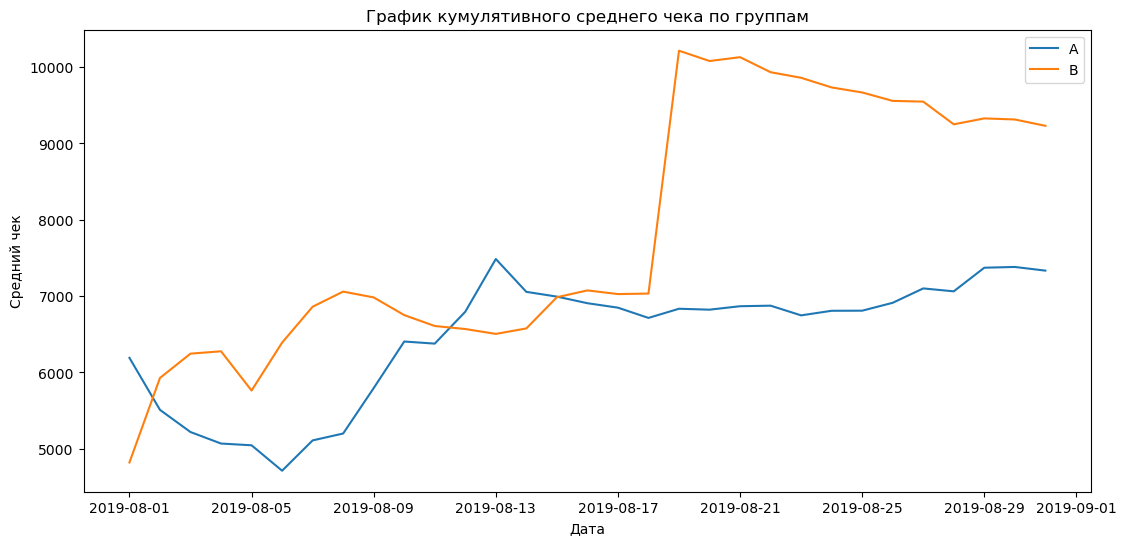

In [12]:
plt.figure(figsize=(13, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()

Так же как в случае с выручкой видим резкий рост в группе B. Примерно 18 августа была совершена крупная покупка в группе B, что сильно повлияло на средний чек в группе B

## График относительного изменения кумулятивного среднего чека группы B к группе A

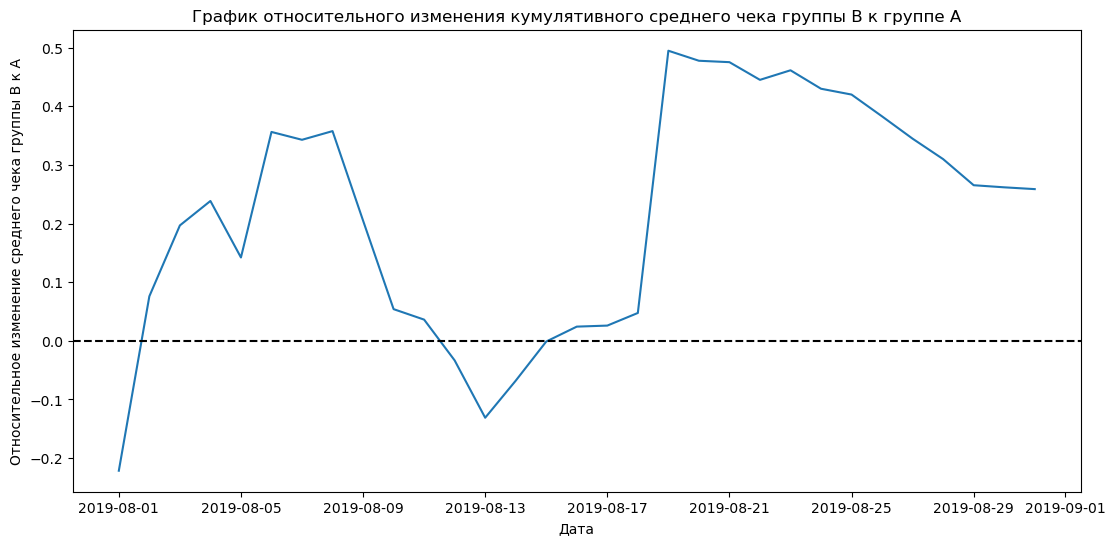

In [13]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(13, 6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/ 
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']) - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего чека группы В к А')
plt.show()

На данном графике наблюдаем значительные изменения от -0,15 до 0,5

## График кумулятивного среднего количества заказов на посетителя по группам

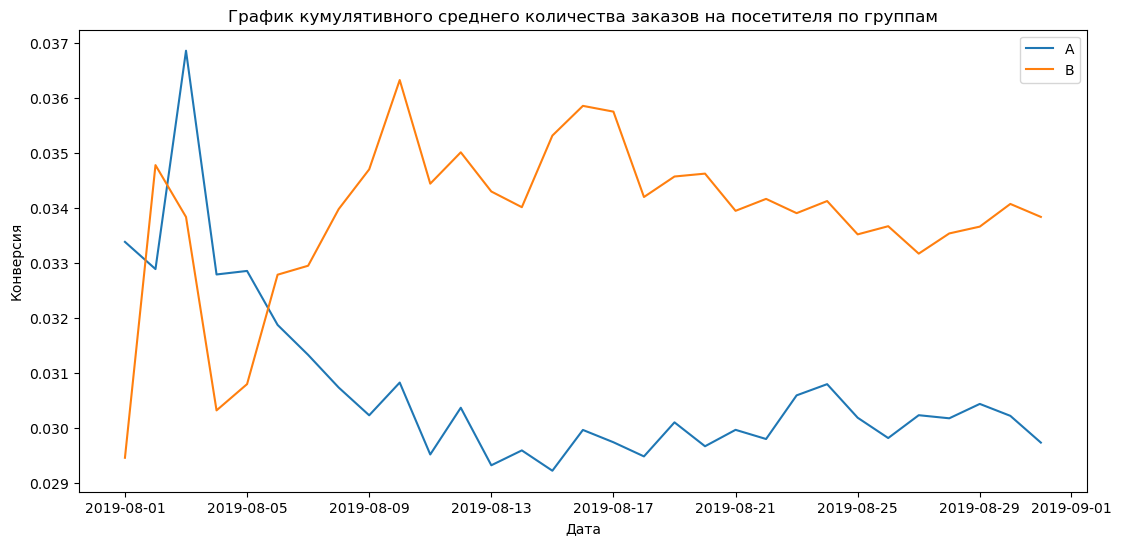

In [14]:
plt.figure(figsize=(13, 6))
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

В начале наблюдения показатели группы A были ощутимо выше, шестого числа коверсия групп сравнялась, после наблюдаем значительный рост группы B и падение конверсии в группе A

## График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

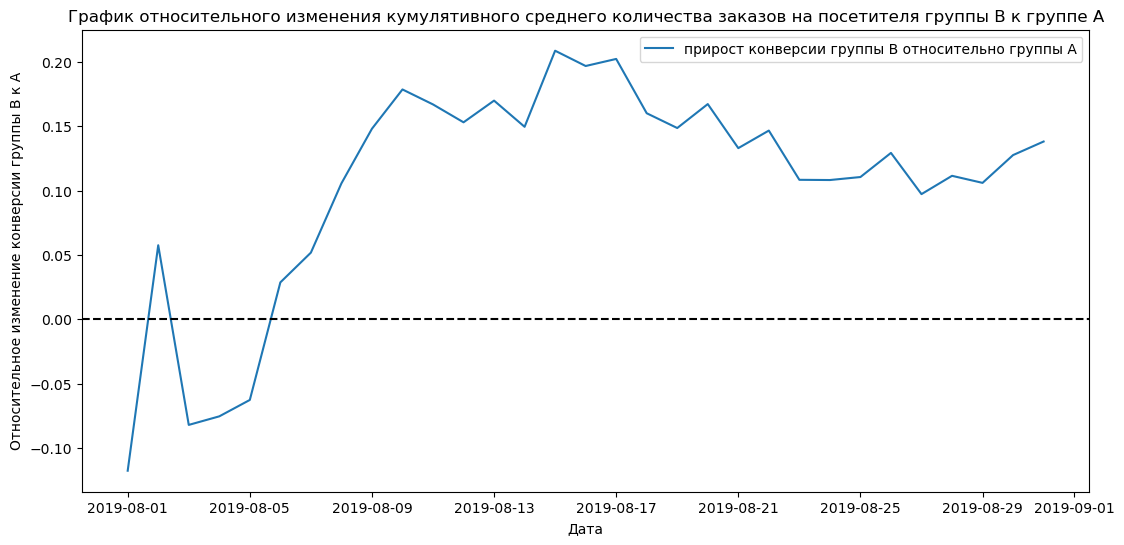

In [15]:
mergedCumulativeConversions = ( cumulativeDataA[['date','conversion']]
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
                              )
plt.figure(figsize=(13, 6))
plt.plot(mergedCumulativeConversions['date'], 
        mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
        label="прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение конверсии группы В к А')
plt.show()

Почти с самого начала видим сильный прирост конверсии в группе B

## Точечный график количества заказов по пользователям

In [16]:
orders_per_user = (orders.drop(['group', 'revenue', 'date'], axis=1)
                   .groupby('visitor_id', as_index=False)
                   .agg({'transaction_id' : pd.Series.nunique})
                  )
orders_per_user.columns = ['visitor_id','orders']
orders_per_user.sort_values(by='orders', ascending=False).head(11)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Таблица с количеством заказов на каждого пользователя

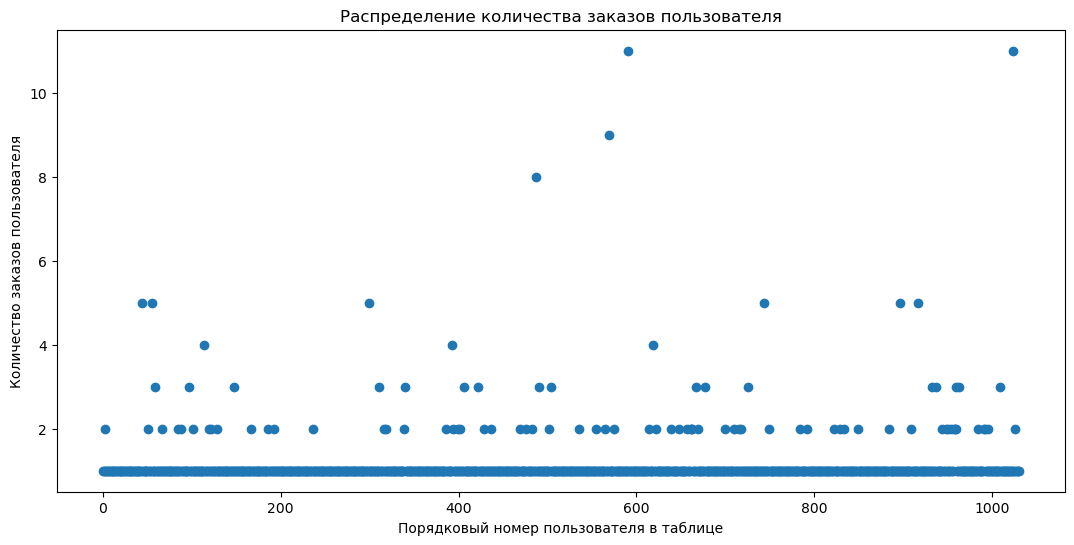

In [17]:
plt.figure(figsize=(13,6))
plt.scatter(pd.Series(range(0,len(orders_per_user['orders']))), orders_per_user['orders'])
plt.title('Распределение количества заказов пользователя')
plt.ylabel('Количество заказов пользователя')
plt.xlabel('Порядковый номер пользователя в таблице')
plt.show()

Большинство пользователей совершают по одному заказу, но есть пользователи которые совершают более десяти заказов, есть уплотнение в районе от двух до пяти заказов

## 95-й и 99-й перцентили количества заказов на пользователя

In [18]:
print(np.percentile(orders_per_user['orders'], [90, 95, 99]))

[1. 2. 4.]


Только 5% пользователей совершают 2 заказа, 1% совершает более 4 заказов

## Точечный график стоимостей заказов

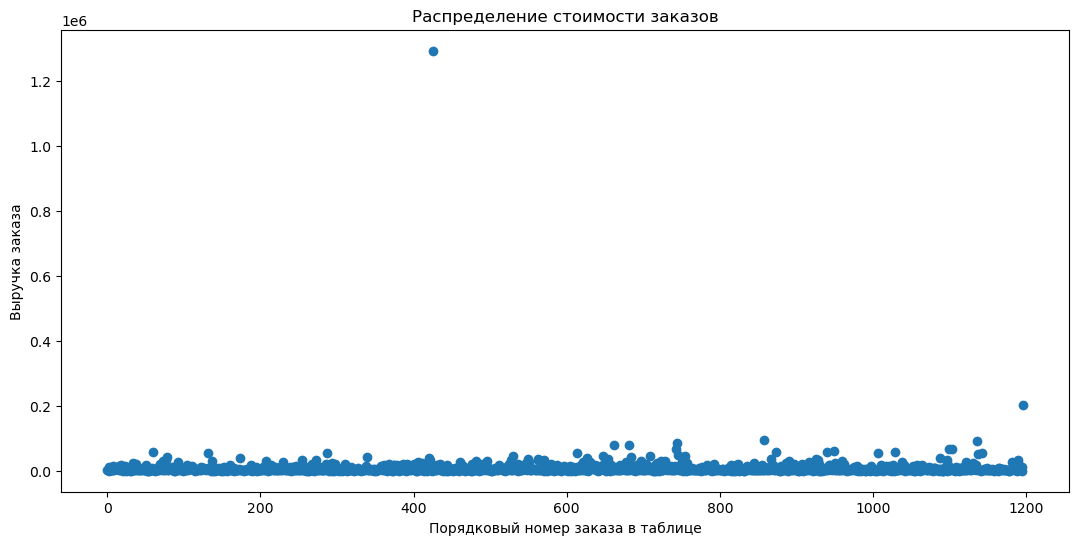

In [19]:
plt.figure(figsize=(13,6))
plt.scatter(pd.Series(range(0,len(orders['revenue']))), orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.ylabel('Выручка заказа')
plt.xlabel('Порядковый номер заказа в таблице')
plt.show()

Видим крупный заказ, более чем на 1,2 млн, он и является выбросом. Уточню график

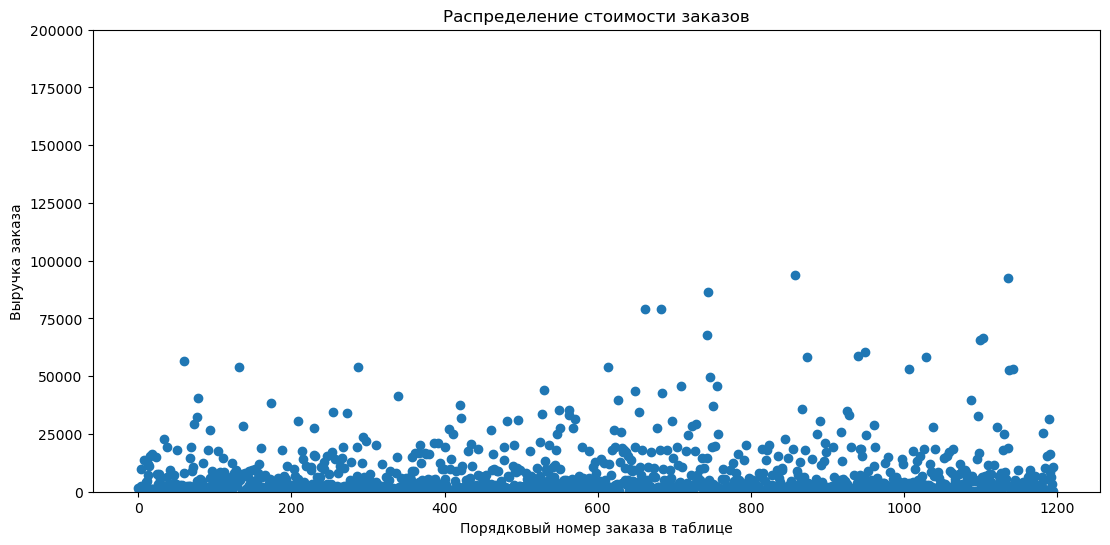

In [20]:
plt.figure(figsize=(13,6))
plt.scatter(pd.Series(range(0,len(orders['revenue']))), orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.ylabel('Выручка заказа')
plt.xlabel('Порядковый номер заказа в таблице')
plt.ylim(0,200000)
plt.show()

Основная масса заказов менее 20 тыс., далее группа с меньшей плотностью заказы от 25 до 100 тыс.

## 95-й и 99-й перцентили стоимости заказов

In [21]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


Основная масса заказов приходится до 18 тыс., заказы 28 тыс. составляют 5%, заказы 58 тыс. составляют 1%. Все что выше 28 тыс. считаем аномалией

## Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [22]:
# создадим таблицы ежедневного количества пользователей по группам
# и таблицы с кумулятивным количеством пользователей к дате по группам
visitors_daily_A = visitors[visitors['group']=='A'][['date', 'visitors']]
visitors_daily_A.columns = ['date', 'visitors_per_date_A']

visitors_daily_B = visitors[visitors['group']=='B'][['date', 'visitors']]
visitors_daily_B.columns = ['date', 'visitors_per_date_B']


visitors_cummulative_A = visitors_daily_A.apply(lambda x: 
                            visitors_daily_A[visitors_daily_A['date'] <= x['date']].agg({
                                'date' : 'max', 'visitors_per_date_A' : 'sum'}), axis=1)
visitors_cummulative_A.columns = ['date', 'visitors_cummulative_A']

visitors_cummulative_B = visitors_daily_B.apply(lambda x: 
                            visitors_daily_B[visitors_daily_B['date'] <= x['date']].agg({
                                'date' : 'max', 'visitors_per_date_B' : 'sum'}), axis=1)
visitors_cummulative_B.columns = ['date', 'visitors_cummulative_B']

In [23]:
# создадим таблицы с количеством заказов и размером выручки по группам
# и затем создадим таблицы с кумулятивным количеством заказов и выручки
orders_daily_A = orders[orders['group']=='A'][['date', 'transaction_id','visitor_id', 
                                               'revenue']].groupby(
    'date', as_index=False).agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
orders_daily_A.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

orders_daily_B = orders[orders['group']=='B'][['date', 'transaction_id','visitor_id', 
                                               'revenue']].groupby(
    'date', as_index=False).agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
orders_daily_B.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']


orders_cummulative_A = orders_daily_A.apply(
    lambda x: orders_daily_A[orders_daily_A['date'] <= x['date']].agg({
                'date' : 'max',
                'orders_per_date_A' : 'sum',
                'revenue_per_date_A' : 'sum'}), axis=1).sort_values(by=['date'])
orders_cummulative_A.columns = ['date', 'orders_сummulative_A', 'revenue_сummulative_A']

orders_cummulative_B = orders_daily_B.apply(
    lambda x: orders_daily_B[orders_daily_B['date'] <= x['date']].agg({
                'date' : 'max',
                'orders_per_date_B' : 'sum',
                'revenue_per_date_B' : 'sum'}), axis=1).sort_values(by=['date'])
orders_cummulative_B.columns = ['date', 'orders_сummulative_B', 'revenue_сummulative_B']

In [24]:
# объединим все созданные таблицы в одну по дате
data = (visitors_daily_A
        .merge(visitors_daily_B, left_on='date', right_on='date', how='left')
        .merge(visitors_cummulative_A, left_on='date', right_on='date', how='left')
        .merge(visitors_cummulative_B, left_on='date', right_on='date', how='left')
        .merge(orders_daily_A, left_on='date', right_on='date', how='left')
        .merge(orders_daily_B, left_on='date', right_on='date', how='left')
        .merge(orders_cummulative_A, left_on='date', right_on='date', how='left')
        .merge(orders_cummulative_B, left_on='date', right_on='date', how='left')
       )

In [25]:
# создадим таблицы с количеством заказов по пользователям для каждой группы
orders_by_visitors_A = orders[orders['group']=='A'].groupby(
    'visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})

orders_by_visitors_A.columns = ['visitor_id', 'orders']

orders_by_visitors_B = orders[orders['group']=='B'].groupby(
    'visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})

orders_by_visitors_B.columns = ['visitor_id', 'orders']

sample_A = pd.concat([orders_by_visitors_A['orders'],
                     pd.Series(0, index=np.arange(
                         data['visitors_per_date_A'].sum() -
                         len(orders_by_visitors_A['orders'])),
                               name='orders')],axis=0)

sample_B = pd.concat([orders_by_visitors_B['orders'],
                     pd.Series(0, index=np.arange(
                         data['visitors_per_date_B'].sum() -
                         len(orders_by_visitors_B['orders'])), 
                               name='orders')],axis=0)

Сформулируем гипотезы:

Н0 : статистически значимых различий в конверсии между группами нет
Н1 : статистически значимые различия в конверсии между группами есть
    
alpha = 0.05

In [26]:
# посчитаем критерий Манна-Уитни к конверсии
# и относительный прирост конверсии группы B

print('Значение p-value для конверсий: {:.3f}'.format(stats.mannwhitneyu(sample_A, sample_B)[1]))

if stats.mannwhitneyu(sample_A, sample_B)[1] < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print('Относительный прирост конверсии группы B: {:.2%}'.format((sample_B.mean()/sample_A.mean()) - 1))

Значение p-value для конверсий: 0.017
Отвергаем нулевую гипотезу
Относительный прирост конверсии группы B: 13.81%


Отвергаем нулевую гипотезу, следственно отличия есть. Относительный прирост конверсии - 13.8%

## Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Гипотезы:

Н0 : статистически значимых различий в среднем чеке между группами нет

Н1 : статистически значимые различия в среднем чеке между группами есть

In [27]:
pvalue_mean_check = stats.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1]

print('Значение p-value для среднего чека: {:.3f}'.format(pvalue_mean_check))

if pvalue_mean_check < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print('Относительный прирост среднего чека группы B: {:.2%}'
        .format((orders.query('group == "B"')['revenue'].mean() / orders.query('group == "A"')['revenue'].mean()) - 1))

Значение p-value для среднего чека: 0.729
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы B: 25.87%


Отвергаем нулевую гипотезу, следственно отличия есть. Относительный прирост чека - 25.8%

## Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Гипотезы:

Н0 : статистически значимых различий в количестве заказов на посетителя между группами нет
    
Н1 : статистически значимые различия в количестве заказов на посетителя между группами есть

In [28]:
visitors_many_orders = pd.concat([orders_by_visitors_A.query('orders > 2')['visitor_id'], 
                                  orders_by_visitors_B.query('orders > 2')['visitor_id']], axis = 0)
visitors_expensive_orders = orders.query('revenue > 28000')['visitor_id']


abnormal_visitors = (pd.concat([visitors_many_orders, visitors_expensive_orders], axis = 0)
                     .drop_duplicates()
                     .sort_values()
                    )

print('Количество аномальных пользователей:',len(abnormal_visitors))
print('Доля аномальных пользователей {:.2%}'.format(len(abnormal_visitors) / len(orders['visitor_id'].unique())))

Количество аномальных пользователей: 74
Доля аномальных пользователей 7.18%


7% пользователей совершили заказы на более 28 тыс. Очистим данные

In [29]:
sample_A_filt = pd.concat(
                    [orders_by_visitors_A[np.logical_not(orders_by_visitors_A['visitor_id']
                            .isin(abnormal_visitors))]['orders'],
                            pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - 
                            len(orders_by_visitors_A['orders'])),
                            name='orders')],
                            axis=0
                         )

sample_B_filt = pd.concat(
                    [orders_by_visitors_B[np.logical_not(orders_by_visitors_B['visitor_id']
                           .isin(abnormal_visitors))]['orders'],
                           pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - 
                           len(orders_by_visitors_B['orders'])),
                           name='orders')],
                           axis=0
                         )

In [30]:
print('Значение p-value для конверсий: {:.3f}'.format(stats.mannwhitneyu(sample_A_filt, sample_B_filt)[1]))

if stats.mannwhitneyu(sample_A_filt, sample_B_filt)[1] < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print('Относительный прирост конверсии группы B: {:.2%}'.format((sample_B_filt.mean() / sample_A_filt.mean()) - 1))

Значение p-value для конверсий: 0.013
Отвергаем нулевую гипотезу
Относительный прирост конверсии группы B: 17.27%


Отвергаем нулевую гипотезу, следственно отличия есть. Относительный прирост конверсии - 17.2%

## Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Гипотезы:

Н0 : статистически значимых различий в среднем чеке заказа между группами нет
    
Н1 : статистически значимые различия в среднем чеке заказа между группами есть

In [31]:
filtered_pvalue_mean_check = stats.mannwhitneyu(
    orders[np.logical_and(orders['group'] == "A", np.logical_not(orders['visitor_id'].isin(abnormal_visitors)))]['revenue'],
    orders[np.logical_and(orders['group'] == "B", np.logical_not(orders['visitor_id'].isin(abnormal_visitors)))]['revenue'])[1]

print('Значение p-value для среднего чека: {:.3f}'.format(filtered_pvalue_mean_check))


if filtered_pvalue_mean_check < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

    
print('Относительный прирост среднего чека группы B: {:.2%}'.format(
    (orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].isin(abnormal_visitors)))]['revenue'].mean()/
     orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].isin(abnormal_visitors)))]['revenue']
     .mean()) - 1))

Значение p-value для среднего чека: 0.738
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы B: -1.96%


В данном случае нельзя отвергнуть нулевую гипотезу. Относительный прирост среднего чека -1.9%

## Решение по результатам теста

По итогам анализа, следует принять решение о остановке тестирования и зафиксировать победу группы B

# Вывод

В начале исследования мы приоритизировали гипотезы с помощю фреймворков ICE и RICE, по итогам проверки была вбрана гипотеза 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

Были построены графики, на которых видны аномалии.

Проведен A/B-тест.

В начале наблюдения показатели группы A были ощутимо выше, шестого числа показатели групп сравнялась, после наблюдаем значительный рост группы B и падение показателей в группе A. Рост группы B связываю с аномальными чеками, которых нет в группе A.

По итогам статистического анализа были сделаны следующие выводы.

Статистические значимые различия в конверсии между группами теста есть, как на сырых, так и на отфильтрованных данных.

Статистических значимых различий в среднем чеке между группами теста нету, как на сырых, так и на отфильтрованных данных.